# Natural Language Processing
## Predict Yelp star ratings from review text

Unstructured data makes up the vast majority of data. Text of business reviews on Yelp are unstructured and can have predictive value. My objective is to be able to predict the Yelp star rating a user provides, given the text of their review.

The models will be assessed base on their coeffecient of determination.

The data can be found here: http://thedataincubator.s3.amazonaws.com/coursedata/mldata/yelp_train_academic_dataset_review.json.gz

### Load and parse the data
Load and parse the json using the `simplejson` library. Then convert it to a `pandas` data frame and remove columns I won't need to free up memory.

In [6]:
import re
import gzip
import nltk
import timeit
import simplejson
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import nltk.tokenize as tokenize
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn import cross_validation, grid_search
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_columns=25

runit = 0

if runit:
    data = gzip.open('yelp_train_academic_dataset_review.json.gz')
    data_content = data.read()
    data.close()
    lines= re.split('\n',data_content)
    json_data = [simplejson.loads(line) for line in lines[:-1]]
    df = pd.DataFrame(json_data)
    del(json_data)
    df.info()

    ### all pasted code here on out
    cols_to_drop = ['date','review_id','type','user_id','votes']
    df.drop(cols_to_drop, axis=1, inplace=True)
    df.info()

    rows = np.random.choice(df.index.values,55000,replace=False)
    sampled_df = df.ix[rows]
    sampled_df.to_json('Yelp_review_text_stars_55000.json')
    del(df)
else:
    sampled_df = pd.read_json('Yelp_review_text_stars_55000.json')
    sampled_df.reset_index(drop=True,inplace=True)

sampled_df.head(5)

,business_id,stars,text
0,_wZTYYL7cutanzAnJUTGMA,3,We had dinner at the Beach House on Friday on ...
1,89O2bCyo92IpEEvgFXqOMw,5,Great cousins! The subs are always good and t...
2,n7G3zKFSgTrl2KE5HpzLcw,5,Had to get a smoothie after 3 hours of shoppin...
3,YZxA6w82eFJFntwqJLln6w,3,No cover for military. That's awesome and fre...
4,W6gPrnthBK7i1pe4ZZlJDQ,4,I don't understand why the ratings for this pl...


## Bag of Words
I will first build a bag of words model. I will build a linear model based on the count of the words in each review.

### Feature Extraction from Text
#### HashingVectorizer
I first need to tokenize the yelp reviews to break them into individual words. For this process I used the `nltk` package and the `HashingVectorizer` from `sklearn`. `HashingVectorizer` uses a hashtable to more efficiently store the large dictionary from the yelp reviews. 

One of the limitations of the `HashingVectorizer` is that is does not record the mapping: if you want to go back and forth that information is lost. However, I am concerned with a BagOfWords model to predict rating stars.  I don't care what words predict 5 stars: `HashingVectorizer` will suffice.

#### Stopwords
Common english language words were filtered using a `nltk` subpackage and the `stopwords` parameter in `HashingVectorizer`. Stop words are words we want to omit because they are common and do not tend to give us any value as to the meaning of reviews. Example of stop words are: "a", "an", "the", "it", "he", "her". 

#### Lemmatization
I also found it necessary to use word lemmatization. Lemmatization is an NLP strategy to lower the vocabulary space by combining words that have the same root. For example, in English, the verb 'to jump' may appear as 'jump', 'jumped', 'jumps', 'jumping'. The base form, 'jump', that one might look up in a dictionary, is called the *lemma* for the word. I use `nltk`'s `WordNetLemmatizer`.

In [7]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

Setup the test and training data sets.

In [8]:
text_train,text_test,stars_train,stars_test = cross_validation.train_test_split(sampled_df['text'],sampled_df['stars'],
                                                                               test_size=0.2, random_state=23)


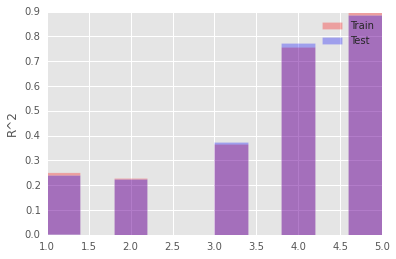

In [9]:
#check our distributions of stars between train and test
stars_train.hist( alpha=0.3 ,stacked=False,normed=True,color='red')
stars_test.hist( alpha=0.3 ,stacked=False,normed=True,color='blue')
plt.legend(['Train','Test'])
f = plt.gcf()
f.set_size_inches(6,4)
plt.ylabel("R^2")
plt.savefig('ML_Yelp_Rev_starhist.png',dpi=300)

#### Model Fitting

I use `SGDRegressor`, which implements a plain stochastic gradient descent learning routine, to fit my bag of words model to the star rating on Yelp. It is well suited for regression problems with a large number of training samples (> 10000). Cross validation was used to validate the test set and prevent overfitting.

The `Pipeline` function of sklearn was used to quickly and easily link preprocessing (`HashingVectorizer`) and estimator (`SGDRegressor`) steps of my machine learning model.

#### N-grams of size 1
I will use a ngram size of one for the first model. Only single words are hashed.

In [11]:
if runit:
    hv_mono = HashingVectorizer(tokenizer=LemmaTokenizer(),norm='l2',ngram_range=(1,1),stop_words=nltk.corpus.stopwords.words('english'))
    hv_mono_counts = hv_mono.fit_transform(sampled_df['text'])
    joblib.dump(hv_mono,'hash_vectorizer_mono.pkl')
    del(hv_mono_counts)
    #fit model
    tic=timeit.default_timer()
    monogram_pipeline = Pipeline([
    ('vect', hv_mono),
    ('lm', linear_model.SGDRegressor(n_iter=6000,alpha=.00001,penalty='l2')),
    ])
    monogram_pipeline.fit(text_train,stars_train)
    toc=timeit.default_timer()
    print toc - tic
    joblib.dump(monogram_pipeline,'monogram_pipeline.pkl')
else:
    nv_mono = joblib.load('hash_vectorizer_mono.pkl')
    monogram_pipeline=joblib.load('monogram_pipeline.pkl')

preds = monogram_pipeline.predict(text_test)
print 'Monogram RMSE: ', mean_squared_error(stars_test,preds)**0.5
print 'Monogram MAE: ', mean_absolute_error(stars_test,preds)
print 'Monogram R^2: ', r2_score(stars_test,preds)

Monogram RMSE:  0.792396804606
Monogram MAE:  0.625059644981
Monogram R^2:  0.620905936123


The score above is the coefficient of determination R^2 of the prediction. So 62% of the variannce in star rating is predictable from monograms of the review text. Let's look at how these predictions line up with the actual data.

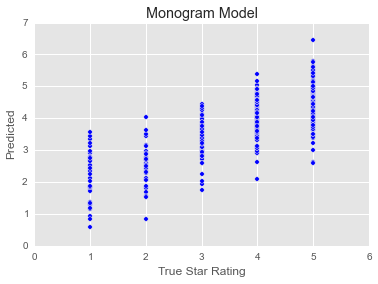

In [6]:
plt.scatter(stars_test[:500],preds[:500])
plt.xlabel('True Star Rating')
plt.ylabel('Predicted')
plt.title('Monogram Model')

#### N-grams of size 2
I will use a ngram size of one for the next model. These bigrams are two adjacent words from the text.

In [12]:
if runit:
    hv_bi = HashingVectorizer(tokenizer=LemmaTokenizer(),norm='l2',ngram_range=(2,2),stop_words=nltk.corpus.stopwords.words('english'))
    hv_bi_counts = hv_bi.fit_transform(sampled_df['text'])
    joblib.dump(hv_bi,'hash_vectorizer_bi.pkl')
    del(hv_bi_counts)
    #fit model
    tic=timeit.default_timer()
    bigram_pipeline = Pipeline([
    ('vect', hv_bi),
    ('lm', linear_model.SGDRegressor(n_iter=6000,alpha=.00001,penalty='l2')),
    ])
    bigram_pipeline.fit(text_train,stars_train)
    toc=timeit.default_timer()
    print toc - tic
    joblib.dump(bigram_pipeline,'bigram_pipeline.pkl')
else:
    hv_bi = joblib.load('hash_vectorizer_bi.pkl')
    bigram_pipeline=joblib.load('bigram_pipeline.pkl')

preds = bigram_pipeline.predict(text_test)
print 'Bigram RMSE: ', mean_squared_error(stars_test,preds)**0.5
print 'Bigram MAE: ', mean_absolute_error(stars_test,preds)
print 'Bigram R^2: ', r2_score(stars_test,preds)

Bigram RMSE:  0.649430728128
Bigram MAE:  0.506666155077
Bigram R^2:  0.745359651404


Bigrams do not do better than monograms. Let's plot these predictions.

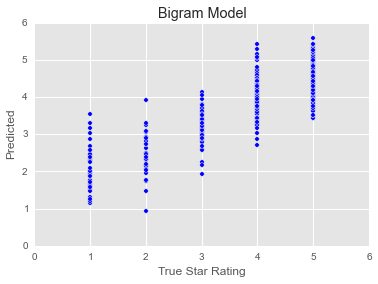

In [8]:
plt.scatter(stars_test[:500],preds[:500])
plt.xlabel('True Star Rating')
plt.ylabel('Predicted')
plt.title('Bigram Model')

In [9]:
if runit:
    hv_monobi = HashingVectorizer(tokenizer=LemmaTokenizer(),norm='l2',ngram_range=(1,2),stop_words=nltk.corpus.stopwords.words('english'))
    hv_monobi_counts = hv_monobi.fit_transform(sampled_df['text'])
    joblib.dump(hv_monobi,'hash_vectorizer_monobi.pkl')
    del(hv_monobi_counts)
    #fit model
    tic=timeit.default_timer()
    monobi_pipeline = Pipeline([
    ('vect', hv_monobi),
    ('lm', linear_model.Ridge()),
    ])
    monobi_pipeline.fit(text_train,stars_train)
    toc=timeit.default_timer()
    print toc - tic
    joblib.dump(monobi_pipeline,'monobi_pipeline.pkl')
else:
    hv_monobi = joblib.load('hash_vectorizer_monobi.pkl')
    monobi_pipeline=joblib.load('monobi_pipeline.pkl')

preds = monobi_pipeline.predict(text_test)
print 'Bi- and Monogram RMSE: ', mean_squared_error(stars_test,preds)**0.5
print 'Bi- and Monogram MAE: ', mean_absolute_error(stars_test,preds)
print 'Bi- and Monogram R^2: ', r2_score(stars_test,preds)

Bi- and Monogram RMSE:  0.659858030787
Bi- and Monogram MAE:  0.515989109455
Bi- and Monogram R^2:  0.737116961314


The bi- and mono-gram model does not perform better than the bigram model.

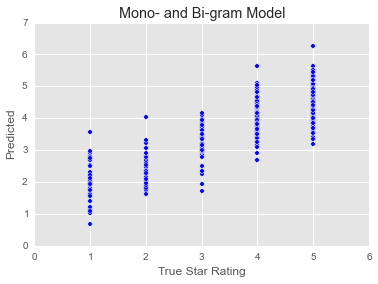

In [10]:
plt.scatter(stars_test[:500],preds[:500])
plt.xlabel('True Star Rating')
plt.ylabel('Predicted')
plt.title('Mono- and Bi-gram Model')

In [18]:
if runit:
    pred_mono_train = monogram_pipeline.predict(text_train)
    pred_bi_train = bigram_pipeline.predict(text_train)
    pred_combined_train = [[p1,p2] for p1,p2 in zip(pred_mono_train,pred_bi_train)]
    lm = linear_model.LinearRegression(normalize=True,n_jobs=2)
    lm.fit(pred_combined_train,stars_train)
    joblib.dump(lm,'LM_monobi.pkl')
else:
    lm = joblib.load('LM_monobi.pkl')

pred_mono_test = monogram_pipeline.predict(text_test)
pred_bi_test = bigram_pipeline.predict(text_test)
pred_combined_test = [[p1,p2] for p1,p2 in zip(pred_mono_test,pred_bi_test)]
preds = lm.predict(pred_combined_test)
print 'Bi- and Monogram Linear Regression RMSE: ', mean_squared_error(stars_test,preds)**0.5
print 'Bi- and Monogram Linear Regression MAE: ', mean_absolute_error(stars_test,preds)
print 'Bi- and Monogram Linear Regression R^2: ', r2_score(stars_test,preds)

Bi- and Monogram Linear Regression RMSE:  0.624587741634
Bi- and Monogram Linear Regression MAE:  0.484675855615
Bi- and Monogram Linear Regression R^2:  0.764468788678


The linear model of the combined predictions from monograms and bigrams has a stronger predictive power than either alone!


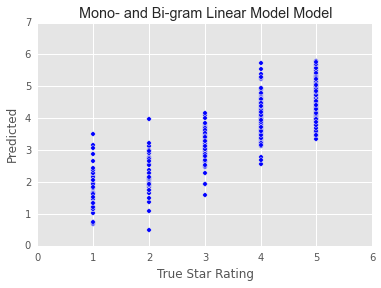

In [23]:
plt.scatter(stars_test[:500],preds[:500])
plt.xlabel('True Star Rating')
plt.ylabel('Predicted')
plt.title('Mono- and Bi-gram Linear Model Model')
f = plt.gcf()
f.set_size_inches(6,4)
plt.savefig('ML_Yelp_Rev_LM.png',dpi=300)

Great! Our model captures 76% of the variation. Now I will round the predictions and cap the values to 1 and 5. This will allow me to assess the accuracy of the model to predict the actual star rating.

In [20]:
#stars_test_pred = lm.predict(pred_combined_test)

def round_limit_preds(pred):
    rndp = np.rint(pred)
    rndp[rndp>5]=5
    rndp[rndp<1]=1
    return rndp

stars_test_pred_rnd = round_limit_preds(preds)

print 'R^2 of pred: ', r2_score(stars_test, preds)
print 'R^2 of rnd : ', r2_score(stars_test, stars_test_pred_rnd)
from sklearn.metrics import accuracy_score
mod_acc = accuracy_score(stars_test,stars_test_pred_rnd)
print 'Accuracy  rnd: ', mod_acc

R^2 of pred:  0.764468788678
R^2 of rnd :  0.734182642237
Accuracy  rnd:  0.623


In [21]:
stars_test_counts = stars_test.value_counts()
print stars_test_counts
bl_acc = (0.+stars_test_counts.values[0])/np.sum(stars_test_counts.values)
print 'Baseline Accuracy: ', bl_acc
print 'Model Improvement over baseline: ', mod_acc - bl_acc

5    3908
4    3409
3    1643
1    1051
2     989
dtype: int64
Baseline Accuracy:  0.355272727273
Model Improvement over baseline:  0.267727272727


### Bag of Words conclusion
My model has an accuracy of .623. This is a significant improvement over the baseline accuracy (If one were to choose the most common class) of .355.

Let's take one final look at the plots of my rounded model.

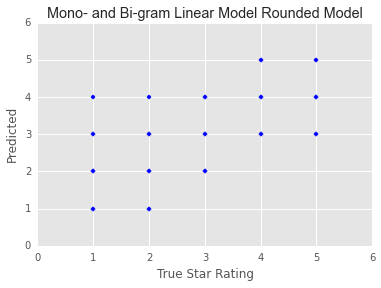

In [24]:
plt.scatter(stars_test[:500],stars_test_pred_rnd[:500])
plt.xlabel('True Star Rating')
plt.ylabel('Predicted')
plt.title('Mono- and Bi-gram Linear Model Rounded Model')
f = plt.gcf()
f.set_size_inches(6,4)
plt.savefig('ML_Yelp_Rev_LMrnd.png',dpi=300)

For true 1- and 2- star ratings, the model is predicting anywhere from 1 to 4. True 3-star ratings get predictions between 2 and 4, which is encouraging.
The 4- and 5- star ratings are usually predicted in the 3-5 range. This makes sense, as it is relatively difficult to determine between 4 and 5 stars.

### Future work
Future work on this could try to categorize 1-2 star reviews from 4-5 star reviews. Turning this into a 2-class good/bad classification may not only improve the predictions, but is also more relatable to the real world. If I am making a decision about whether I am going to a business based on the yelp stars, there is no discernable difference between 4 and 5 star rated businesses. However, I do care about the difference between a 4-star and a 2-star business.

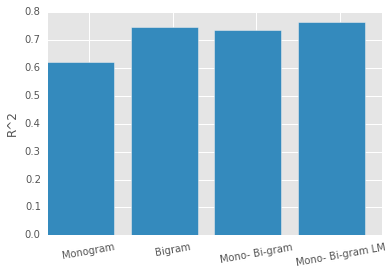

In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.bar([1,2,3,4],[0.620905936123, 0.745359651404, 0.737116961314, 0.764468788678, ])
plt.xticks([1.5,2.5,3.5,4.5], ['Monogram','Bigram','Mono- Bi-gram','Mono- Bi-gram LM'],rotation=10)
#plt.gca().set_xticklabel(['City','LatLong','Attribute','Category'])
#plt.g
#plt.xticks(['City','LatLong','Attribute','Category'])
f = plt.gcf()
f.set_size_inches(6,4)
plt.ylabel("R^2")
plt.savefig('NLP_Yelp_Rev.png',dpi=300)

### Top restaurant bigrams

Looking at only reviews of restaurants I next wanted to identify word pairs in reviews that are more likely than the individual words alone. These might be strongly indicative of "foodie" type words that you might expect to find in a yelp review such as "huevos rancheros".

We can find word pairs that are unlikely to occur consecutively based on the underlying probability of their words.

Mathematically, if $p(w)$ be the probability of a word w and $p(w1w2)$ is the probability of the bigram $w1w2$, then we want to look at word pairs $w1w2$ where the statistic

$p(w1w2)/p(w1)/p(w2)$

is high.

This metric is, however, problematic when $p(w_1)$ and/or $p(w_2)$ are small. This can be fixed with Bayesian smoothing or additive smoothing which essentially adds a constant factor to all probabilities. This factor sets the scale for the number of appearances a word must be used in the overall corpus before it is considered relevent.

First I need to load in a second data set that idenitifies which businesses are restaurants and do an SQL style join on my two pandas dataframes. This will allow me to select reviews that only correspond to restaurants and by extension special food bigrams.

In [91]:
data = gzip.open('../ML_Yelp_BusFeatures/yelp_train_academic_dataset_business.json.gz')
data_content_biz = data.read()
data.close()
lines= re.split('\n',data_content_biz)
json_data = [simplejson.loads(line) for line in lines[:-1]]
dfbiz = pd.DataFrame(json_data)

restaurant = []
for i in dfbiz.index:
    restaurant.append(sum([1 for cat in dfbiz.iloc[i]['categories'] if re.match('Restaurants',cat)]))
dfbiz['restaurant'] = restaurant
df_big = pd.merge(sampled_df,dfbiz,on='business_id')
df_rest = df_big[df_big['restaurant']==1]

### CountVectorizer

Previously I used `HashingVectorizer` to take advantage of its smaller size and memory efficiency. As discussed before, `HashingVectorizer` cannot give you backward compatibility: you lose what word corresponds to what index. Since I now want to know what the words are, I switched over to `CountVectorizer`.

In [92]:
tic = timeit.default_timer()
cvbi = CountVectorizer(tokenizer=LemmaTokenizer(),ngram_range=(2,2),stop_words=nltk.corpus.stopwords.words('english'))
bi = cvbi.fit_transform(df_rest['text'])
cvmono = CountVectorizer(tokenizer=LemmaTokenizer(),ngram_range=(1,1),stop_words=nltk.corpus.stopwords.words('english'))
mono = cvmono.fit_transform(df_rest['text'])
bi_keys = cvbi.vocabulary_.keys() 
mono_keys = cvmono.vocabulary_.keys() 
bi_keys_split = [re.split('\s',key) for key in bi_keys]
toc = timeit.default_timer()
print toc - tic

### Bayesian smoothing function

I tried several different approaches for setting the alpha factor (as can be seen in the commented out lines). In general, an alpha set around the mean count of all words appeared to be roughly appropriate.

In [93]:
def bayesian_smooth(vocab,keys,data,alpha_factor=1):
    N = data.sum()
    d = float(len(keys))
    count = np.array(data.sum(0))[0]
    print np.mean(count)
    bayes = {}
    for key in keys:
        bayes[key] = float((count[vocab[key]]+alpha_factor))
    return bayes

In [95]:
monoalpha = 46
bialpha = 2
mono_vocab_smooth = bayesian_smooth(cvmono.vocabulary_,cvmono.vocabulary_.keys(),mono,monoalpha)
bi_vocab_smooth = bayesian_smooth(cvbi.vocabulary_,cvbi.vocabulary_.keys(),bi,bialpha)

48.9940019453
3.38991997963


### Initial results

I calculated p_w and built the results into a dataframe for analysis and selection of the top 100.

In [96]:
p_w = [bi_vocab_smooth[b]/(mono_vocab_smooth[s[0]]*mono_vocab_smooth[s[1]]) for b,s in zip(bi_keys,bi_keys_split)]
dfq4 = pd.DataFrame({'prob w':p_w,
        'bi keys':bi_keys,
        'bi keys split':bi_keys_split})
dfq4 = dfq4.sort('prob w',ascending=False)
dfq4 = dfq4[dfq4['prob w'] != np.inf]
print dfq4['prob w'].describe()
dfq4.head()

count    7.931730e+05
mean     6.182152e-05
std      1.828306e-04
min      4.299308e-09
25%      1.356359e-06
50%      6.019407e-06
75%      2.881734e-05
max      5.206706e-03
Name: prob w, dtype: float64


,bi keys,bi keys split,prob w
370425,hong kong,"[hong, kong]",0.005207
141328,pei wei,"[pei, wei]",0.005072
346932,hush puppy,"[hush, puppy]",0.005056
9790,panna cotta,"[panna, cotta]",0.004934
209469,patatas bravas,"[patatas, bravas]",0.004611


Slightly more in depth

Where does a phrase such as "huevos rancheros" appear in our list? I picked out the top phrase, huevos rancheros, and the 100th phrase to put them side by side.

In [97]:
x = dfq4.set_index('bi keys')
top100 = list(dfq4['bi keys'][:100])
#print type(top100)
print x.xs(top100[0])
print x.xs('huevos rancheros')
print x.xs(top100[-1])
top100

bi keys split    [hong, kong]
prob w            0.005206706
Name: hong kong, dtype: object
bi keys split    [huevos, rancheros]
prob w                   0.004504505
Name: huevos rancheros, dtype: object
bi keys split    [tammie, coe]
prob w             0.002539913
Name: tammie coe, dtype: object


[u'hong kong',
 u'pei wei',
 u'hush puppy',
 u'panna cotta',
 u'patatas bravas',
 u'huevos rancheros',
 u'amuse bouche',
 u'ami gabi',
 u'pf chang',
 u'bok choy',
 u'dac biet',
 u'tres lech',
 u'kung pao',
 u'lotus siam',
 u'monte carlo',
 u'thit nuong',
 u'osso bucco',
 u'loco moco',
 u'moscow mule',
 u'pet peeve',
 u'conveyor belt',
 u'croque madame',
 u'rula bula',
 u'pina colada',
 u'wolfgang puck',
 u'mon ami',
 u'lactose intolerant',
 u'prix fixe',
 u'santa fe',
 u'joel robuchon',
 u'tilted kilt',
 u'pinot noir',
 u'hustle bustle',
 u'cabo wabo',
 u'har gow',
 u'scantily clad',
 u'hubert keller',
 u'arnold palmer',
 u'agua frescas',
 u'beaten path',
 u'haricot verts',
 u'bo hue',
 u'cochinita pibil',
 u'harry potter',
 u'cave creek',
 u'butternut squash',
 u'kee mao',
 u'tikka masala',
 u'molecular gastronomy',
 u'valle luna',
 u'julian serrano',
 u'stainless steel',
 u'gordon ramsay',
 u'banh mi',
 u'krispy kreme',
 u'planet hollywood',
 u'malai kofta',
 u'sauvignon blanc',
 u'm

It works! (mostly)

I definitely see key word pairs (mostly for various ethnic foods, which is not surprising) including the alluring "spam musubi" which apparently is some horrible spam based 7/11 food that Hawaiians love. Who knew?